<a href="https://colab.research.google.com/github/satani99/generative_deep_learning/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import auth

# auth.authenticate_user()

In [2]:
# !curl https://sdk.cloud.google.com | bash

In [3]:
# !gcloud init --skip-diagnostics

In [4]:
!gsutil cp gs://quickdraw_dataset/full/numpy_bitmap/camel.npy .


Copying gs://quickdraw_dataset/full/numpy_bitmap/camel.npy...
- [1 files][ 90.8 MiB/ 90.8 MiB]                                                
Operation completed over 1 objects/90.8 MiB.                                     


In [5]:
import torch.nn as nn 
import torch 
import torchvision.utils as vutils

In [6]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [7]:
# THE DISCRIMINATOR
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.conv0 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout()
    self.conv1 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.linear = nn.Linear(2048, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.dropout(self.relu(self.conv0(x)))
    x = self.dropout(self.relu(self.conv1(x)))
    x = self.dropout(self.relu(self.conv2(x)))
    x = self.dropout(self.relu(self.conv3(x)))
    out = self.sigmoid(self.linear(x.view(-1, 2048)))
    return out





In [8]:
# THE GENERATOR 
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.linear = nn.Linear(100, 3136)
    self.batchnorm0 = nn.BatchNorm1d(3136)
    self.relu = nn.ReLU()
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.conv0 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.batchnorm1 = nn.BatchNorm2d(128)
    self.conv1 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
    self.batchnorm2 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1) 
    self.batchnorm3 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1) 
    self.tanh = nn.Tanh() 

  def forward(self, x):
    x = self.linear(x)
    x = self.relu(self.batchnorm0(x))
    x = self.upsample(x.view(-1, 64, 7, 7))
    x = self.relu(self.batchnorm1(self.conv0(x)))
    x = self.upsample(x)
    x = self.relu(self.batchnorm2(self.conv1(x)))
    x = self.relu(self.batchnorm3(self.conv2(x)))
    out = self.tanh(self.conv3(x)) 
    return out 






In [9]:
netG = Generator() .to(device)
netD = Discriminator().to(device) 

In [10]:
import torch.optim as optim 

criterion = nn.BCELoss() 

fixed_noise = torch.randn(64, 100, 1, 1, device=device)

real_label = 1.
fake_label = 0. 

optimizerD = optim.Adam(netD.parameters(), lr=0.0008)
optimizerG = optim.Adam(netG.parameters(), lr=0.0008)

In [42]:
import numpy as np 
from torch.utils.data import Dataset, DataLoader 
 
class GANDataset(Dataset):
  def __init__(self, np_file_path):
    self.files = np_file_path 
  
  def __getitem__(self, index):
    x = np.load(self.files)[index]
    x = torch.from_numpy(x).float()
    return x 

  def __len__(self):
    return len(self.files)

In [45]:
import torchvision.transforms as transforms
dataset = GANDataset('/content/camel.npy')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=1)

In [14]:
img_list = []
G_losses = []
D_losses = [] 
iters = 0

print("Starting Training Loop...")

for epoch in range(2000):
  for i, data in enumerate(dataloader):
    netD.zero_grad() 

    real_cpu = data.to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

    output = netD(real_cpu.view(18, 1, 28, 28)).view(-1)

    errD_real = criterion(output, label)

    errD_real.backward()
    D_x = output.mean().item() 

    noise = torch.randn(b_size, 100, 1, 1, device=device)

    fake = netG(noise.view(-1, 100))
    label.fill_(fake_label)

    output = netD(fake.detach()).view(-1)

    errD_fake = criterion(output, label) 

    errD_fake.backward()
    D_G_z1 = output.mean().item() 

    errD = errD_real + errD_fake 

    optimizerD.step()

    netG.zero_grad()
    label.fill_(real_label)

    output = netD(fake).view(-1)

    errG = criterion(output, label)

    errG.backward()
    D_G_z2 = output.mean().item()

    optimizerG.step() 

    if i % 50 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' % (epoch, 2000, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2)) 

    G_losses.append(errG.item())
    D_losses.append(errD.item())

    if (iters % 500 == 0) or ((epoch == 2000-1) and (i == len(dataloader)-1)):
      with torch.no_grad():
        fake = netG(fixed_noise.view(-1, 100)).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    iters += 1
    

Starting Training Loop...
[0/2000][0/1]	Loss_D: 0.6563	Loss_G: 0.7327	D(x): 0.9996	D(G(z)): 0.4810 / 0.4806
[1/2000][0/1]	Loss_D: 0.6589	Loss_G: 0.7360	D(x): 0.9969	D(G(z)): 0.4809 / 0.4791
[2/2000][0/1]	Loss_D: 0.6554	Loss_G: 0.7391	D(x): 0.9955	D(G(z)): 0.4783 / 0.4776
[3/2000][0/1]	Loss_D: 0.6513	Loss_G: 0.7382	D(x): 0.9997	D(G(z)): 0.4785 / 0.4780
[4/2000][0/1]	Loss_D: 0.6514	Loss_G: 0.7424	D(x): 0.9999	D(G(z)): 0.4786 / 0.4760
[5/2000][0/1]	Loss_D: 0.6439	Loss_G: 0.7453	D(x): 1.0000	D(G(z)): 0.4747 / 0.4746
[6/2000][0/1]	Loss_D: 0.6409	Loss_G: 0.7526	D(x): 0.9999	D(G(z)): 0.4731 / 0.4711
[7/2000][0/1]	Loss_D: 0.6388	Loss_G: 0.7557	D(x): 0.9998	D(G(z)): 0.4719 / 0.4697
[8/2000][0/1]	Loss_D: 0.6348	Loss_G: 0.7577	D(x): 0.9997	D(G(z)): 0.4698 / 0.4688
[9/2000][0/1]	Loss_D: 0.6246	Loss_G: 0.7654	D(x): 1.0000	D(G(z)): 0.4645 / 0.4652
[10/2000][0/1]	Loss_D: 0.6261	Loss_G: 0.7763	D(x): 0.9998	D(G(z)): 0.4652 / 0.4602
[11/2000][0/1]	Loss_D: 0.6175	Loss_G: 0.7827	D(x): 1.0000	D(G(z)): 0.46

In [15]:
noise = torch.randn(64, 100, 1, 1, device=device)
fake = netG(noise.view(-1, 100))

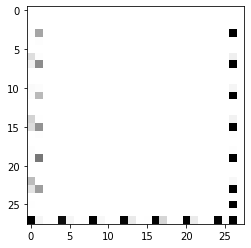

In [34]:
x = fake.cpu().detach().numpy()
# x.shape
plt.imshow(x[12].reshape(28,28), cmap="gray")
# pred = netD(x)

In [46]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")
parser.add_argument('-f')

opt = parser.parse_args()
print(opt)

cuda = True if torch.cuda.is_available() else False


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

for epoch in range(1):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

Namespace(b1=0.5, b2=0.999, batch_size=64, channels=1, f='/root/.local/share/jupyter/runtime/kernel-42dac71e-40b9-42e1-89b9-d8bf7be2bb19.json', img_size=32, latent_dim=100, lr=0.0002, n_cpu=8, n_epochs=200, sample_interval=400)
[Epoch 0/200] [Batch 0/938] [D loss: 0.693183] [G loss: 0.681133]
[Epoch 0/200] [Batch 1/938] [D loss: 0.693097] [G loss: 0.681691]
[Epoch 0/200] [Batch 2/938] [D loss: 0.693039] [G loss: 0.682252]
[Epoch 0/200] [Batch 3/938] [D loss: 0.693100] [G loss: 0.682836]
[Epoch 0/200] [Batch 4/938] [D loss: 0.692852] [G loss: 0.683405]
[Epoch 0/200] [Batch 5/938] [D loss: 0.692817] [G loss: 0.683932]
[Epoch 0/200] [Batch 6/938] [D loss: 0.692582] [G loss: 0.684550]
[Epoch 0/200] [Batch 7/938] [D loss: 0.692470] [G loss: 0.685056]
[Epoch 0/200] [Batch 8/938] [D loss: 0.692412] [G loss: 0.685359]
[Epoch 0/200] [Batch 9/938] [D loss: 0.692079] [G loss: 0.685935]
[Epoch 0/200] [Batch 10/938] [D loss: 0.691740] [G loss: 0.686481]
[Epoch 0/200] [Batch 11/938] [D loss: 0.69144